In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import xgboost as xgb

from datetime import date
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from torch import nn
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

from transformers import BertTokenizer, BertModel

import warnings
warnings.filterwarnings('ignore')

# Data exloration and cleaning

Load and display structured data:

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,user_id,target,name,sex,dob,location,location_population,location_from,location_from_population,occupation,hobbies,daily_commute,friends_number,relationship_status,education,credit_card_type
0,0,1,Halina,NaN,1982-08-07,Piastów,22732,Piastów,22732,Teaching professionals,Fitness,46.0,196,Single,NaN,Visa
1,1,0,Eustachy,male,1971-10-28,Sokółka,18331,Sokółka,18331,General and keyboard clerks,"LARPing,Foreign language learning,Netball",55.0,243,Single,NaN,NaN
2,2,1,Egon,NaN,2000-07-05,Łaskarzew,4879,Łaskarzew,4879,Protective services workers,"Bodybuilding,Kabaddi",90.0,191,In relationship,3.0,NaN
3,3,0,Eulalia,female,1992-06-10,Bydgoszcz,352313,Bydgoszcz,352313,Customer services clerks,Badminton,88.0,164,In relationship,3.0,Visa
4,4,0,Hilary,NaN,1975-01-09,Osieczna,2322,Poznań,538633,Refuse workers and other elementary workers,"Fitness,Embroidery,Lacemaking",40.0,119,Married with kids,5.0,NaN


## Data exploration

Show dataframe info:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   4000 non-null   int64  
 1   target                    4000 non-null   int64  
 2   name                      3982 non-null   object 
 3   sex                       3616 non-null   object 
 4   dob                       3606 non-null   object 
 5   location                  4000 non-null   object 
 6   location_population       4000 non-null   int64  
 7   location_from             4000 non-null   object 
 8   location_from_population  4000 non-null   int64  
 9   occupation                4000 non-null   object 
 10  hobbies                   3320 non-null   object 
 11  daily_commute             3595 non-null   float64
 12  friends_number            4000 non-null   int64  
 13  relationship_status       3607 non-null   object 
 14  educatio

There are a lot of missing values. Let's print and visualise the number of missing values in each column:

In [4]:
df.isna().sum()

user_id                       0
target                        0
name                         18
sex                         384
dob                         394
location                      0
location_population           0
location_from                 0
location_from_population      0
occupation                    0
hobbies                     680
daily_commute               405
friends_number                0
relationship_status         393
education                   408
credit_card_type            428
dtype: int64

<Axes: >

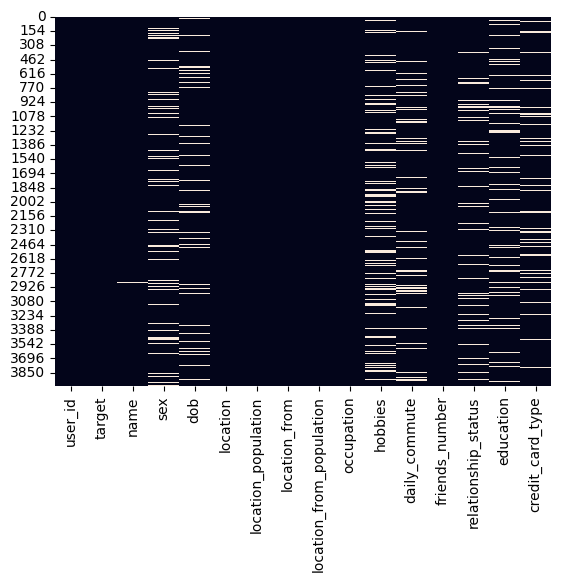

In [5]:
sns.heatmap(df.isnull(), cbar=False)

Plot the crosstab to see, how the target variable is distributed between genders:

<Axes: xlabel='sex', ylabel='target'>

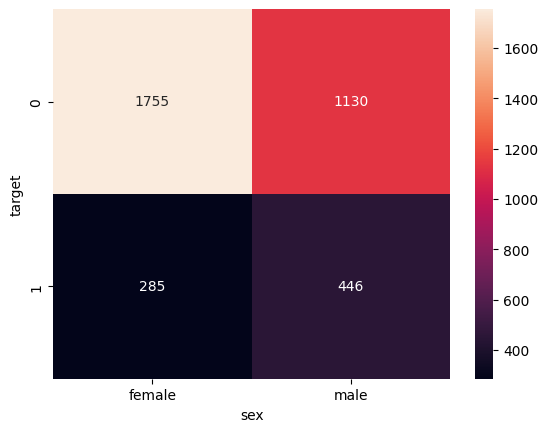

In [6]:
sns.heatmap(pd.crosstab(df['target'], df['sex']), annot=True, fmt='g')

It can be observed, that men are more likely to buy the long-term gym subscription.

Let's see how the relationship status is connected with a target feature:

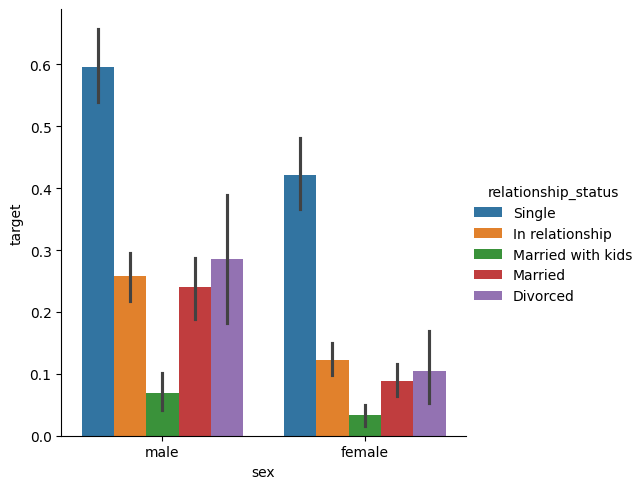

In [7]:
sns.catplot(data=df, y="target", hue='relationship_status', x='sex',kind="bar")

As expected, the highest percentage of users interested in gym subscription is among the people who are single and lowest through married people with kids.

Let's create violin plot to see the distribution of daily_commute feature:

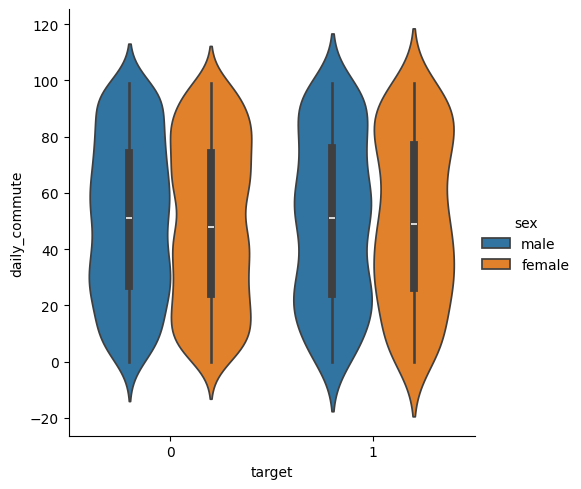

In [8]:
sns.catplot(data=df, x='target', y="daily_commute", hue='sex', kind="violin")

The distributions look similar for both target values, so the daily_commute value does not seem to have a huge impact.

Let's see the barplot for occupation groups:

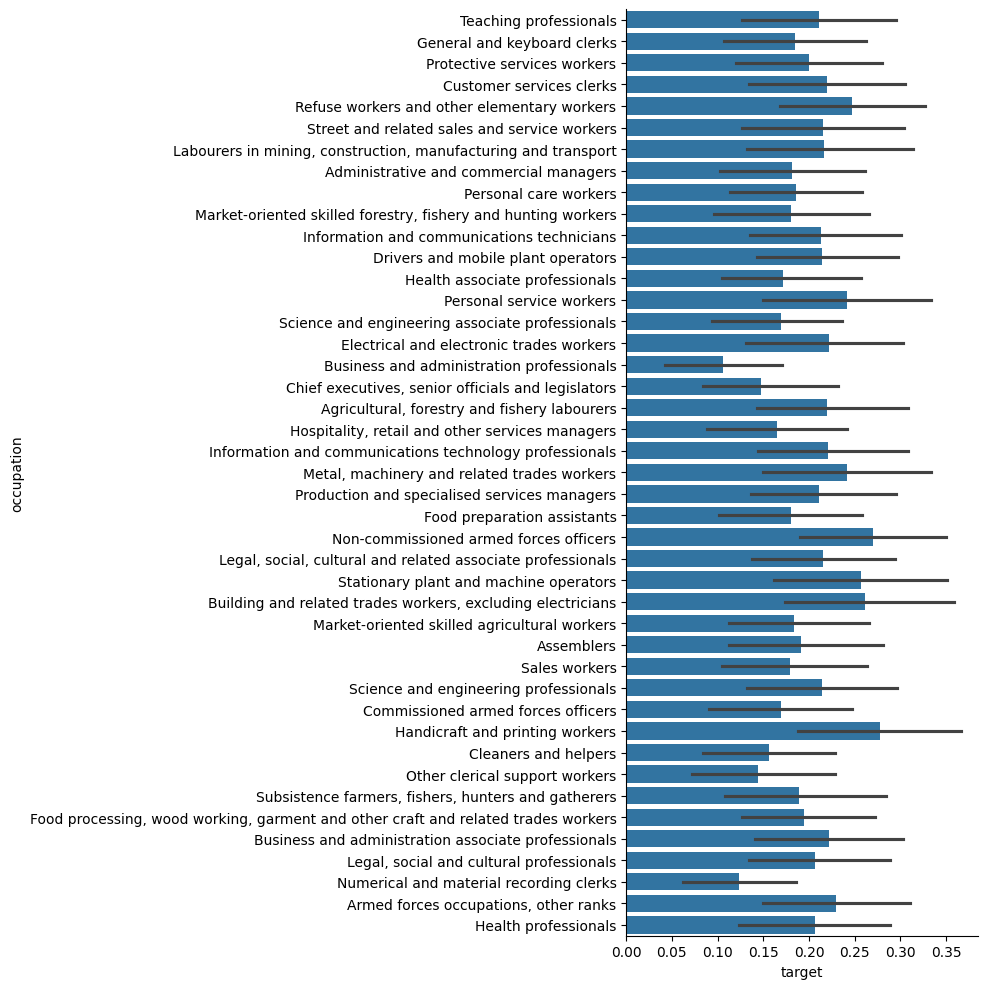

In [9]:
sns.catplot(data=df, x="target", y='occupation',kind="bar",height=10)

It can be seen that, the lowest probability of buying gym subscription is through 'Business and administration professionals' and the highest is through 'Handicraft and printing workers' and 'Arm forces officers'.

## Filling missing values:

Firstly, drop the records with missing name:

In [130]:
df.dropna(subset=['name'], inplace=True)

Let's start with filling missing 'sex' values. In Polish language all (or almost all) female first names end with letter 'a'. Missing values of 'sex' feature can be filled based on this fact. To be sure this is true, the number of all female users is counted as well as the number of all females whos name ends with letter 'a'. This numbers are the same, so the method can be applied.

In [131]:
df[df.sex == 'female']['name'].count()

2040

In [132]:
df[(df.sex == 'female') & (df.name.str.endswith('a'))]['name'].count()

2040

In [133]:
nan_mask = df['sex'].isna()
df.loc[nan_mask, 'sex'] = np.where(df.loc[nan_mask, 'name'].str.endswith('a'), 'female', 'male')

Switch from 'date of birth' feature to 'age':

In [134]:
# change "dob" column data type to datetime
df['dob'] = pd.to_datetime(df['dob'])

# function for calculating age:
def dob_to_age(dob): 
    dob = dob.date() 
    today = date.today() 
    return today.year - dob.year - ((today.month,  today.day) < (dob.month,  dob.day))

# create 'age' column
df['age'] = df['dob'].apply(dob_to_age)

# drop 'dob' column
df.drop(['dob'], axis=1, inplace=True)

Let's plot the age distribution in the dataset:

<Axes: xlabel='age', ylabel='Count'>

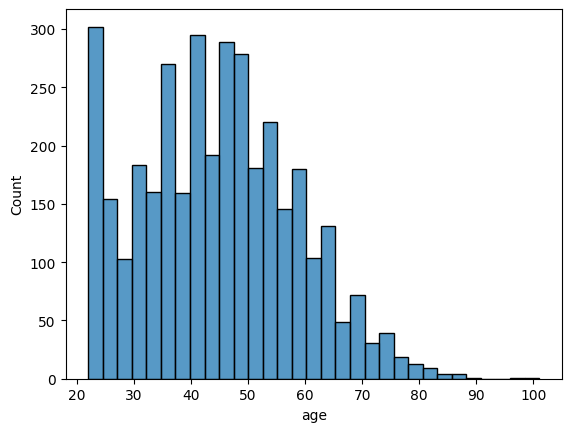

In [135]:
sns.histplot(x='age', data=df)

Fill missing 'age' values with mean:

In [136]:
df['age'].fillna(df['age'].mean(), inplace=True)

Fill missing 'daily commute' values with mean:

In [137]:
df['daily_commute'].fillna(df['daily_commute'].mean(), inplace=True)

Let's plot the daily commute distribution:

<Axes: xlabel='daily_commute', ylabel='Count'>

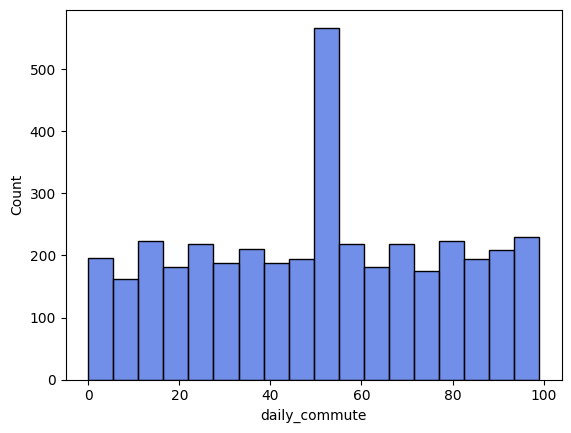

In [138]:
sns.histplot(x='daily_commute', data=df, color='royalblue')

Fill missing relationship status and credit card type values with random values from each column. This will keep the distribution of categories in the dataset.

In [139]:
def na_randomfill(series):
    na_mask = pd.isnull(series)   # boolean mask for null values
    n_null = na_mask.sum()        # number of nulls in the Series
    
    if n_null == 0:
        return series             # if there are no nulls, no need to resample
    
    # Randomly sample the non-null values from our series
    #  only sample this Series as many times as we have nulls 
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=0)

    # This ensures our new values will replace NaNs in the correct locations
    fill_values.index = series.index[na_mask]
    
    return series.fillna(fill_values)

df['relationship_status'] = na_randomfill(df['relationship_status'])
df['credit_card_type'] = na_randomfill(df['credit_card_type'])

<Axes: xlabel='count', ylabel='relationship_status'>

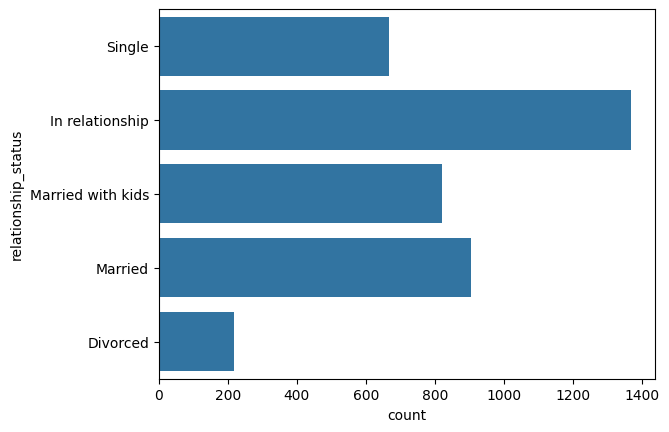

In [140]:
sns.countplot(data=df, y="relationship_status")

<Axes: xlabel='count', ylabel='credit_card_type'>

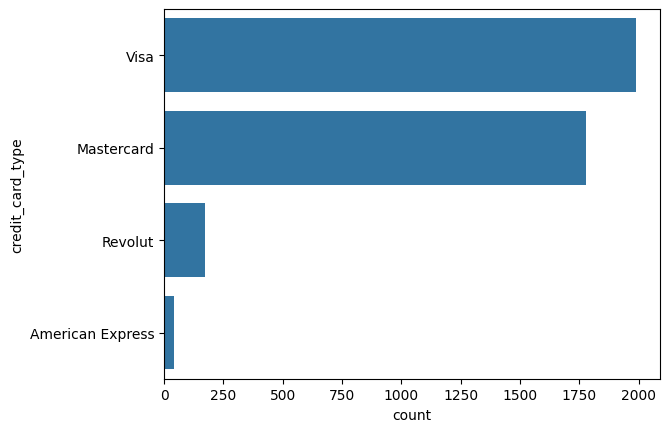

In [141]:
sns.countplot(data=df, y="credit_card_type")

Fill missing education values with the most common value, which is 4:

In [142]:
df['education'].fillna(df['education'].mode().values[0], inplace=True)

<Axes: xlabel='education', ylabel='count'>

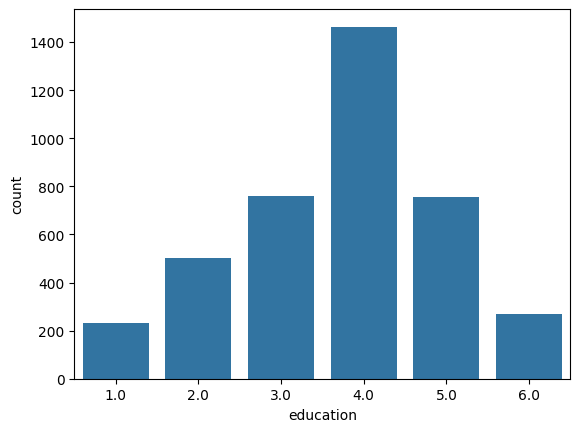

In [143]:
sns.countplot(data=df, x="education")

Plot friends number distribution:

<Axes: xlabel='friends_number', ylabel='Count'>

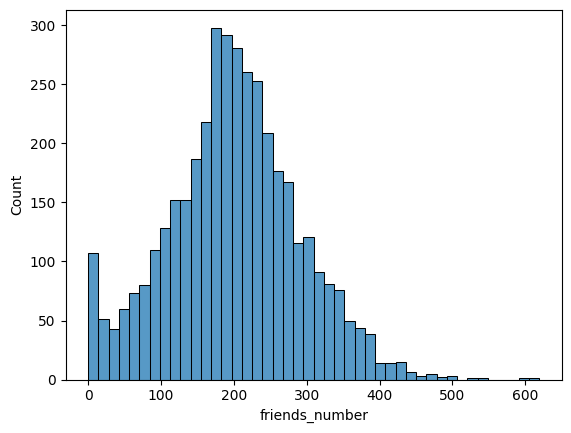

In [144]:
sns.histplot(data=df, x='friends_number')

In [145]:
df.isna().sum()

user_id                       0
target                        0
name                          0
sex                           0
location                      0
location_population           0
location_from                 0
location_from_population      0
occupation                    0
hobbies                     678
daily_commute                 0
friends_number                0
relationship_status           0
education                     0
credit_card_type              0
age                           0
dtype: int64

In [146]:
df.nunique()

user_id                     3982
target                         2
name                         205
sex                            2
location                     644
location_population          635
location_from                649
location_from_population     638
occupation                    43
hobbies                     2736
daily_commute                101
friends_number               438
relationship_status            5
education                      6
credit_card_type               4
age                           71
dtype: int64

The only column with missing values left is hobbies. Let's fill them with 'no_hobbies' string. Then, encode the hobbies using MultiLabelBinarizer, so each column represent one hobby from the list of all hobbies.

In [147]:
# Fill missing values:
df['hobbies'].fillna("no_hobbies", inplace=True)

# Split the hobbies string to list of hobbies:
encoded = df['hobbies'].to_list()
encoded = [s.split(",") for s in encoded]

# Create, fit and transform MultiLabelBinarizer
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(encoded)

# Add encoded hobbies to dataframe
df_encoded = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df, df_encoded], axis=1)

# Drop initial hobbies column
df.drop(columns=["hobbies"], inplace=True)

Now, encode categorical features to numerical values. For sex column, we use LabelEncoder to swich from male/female to 0/1. For 'occupation', 'relationship_status' and 'credit_card_type' clumns we use OneHotEncoder to create a column for each category in the initial column.

In [148]:
def label_encode(series):
    """
    Label encode a Pandas Series.
    
    Parameters:
    - series (pd.Series): The series to be encoded.
    
    Returns:
    - encoded_series (np.array): The label encoded array.
    """
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the series
    encoded = le.fit_transform(series)
    
    return encoded

def one_hot_encode_column(df, column_name):
    """
    One-hot encode a specific column in a Pandas DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to be encoded.
    - column_name (str): The name of the column to be one-hot encoded.
    
    Returns:
    - df_encoded (pd.DataFrame): The DataFrame with the specified column one-hot encoded.
    """
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)
    
    # Fit and transform the specified column
    encoded_array = encoder.fit_transform(df[[column_name]])
    
    # Get the feature names for the encoded columns
    feature_names = encoder.get_feature_names_out([column_name])
    
    # Create a DataFrame with the encoded columns
    df_encoded = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)
    
    # Concatenate the original DataFrame with the encoded DataFrame
    df_encoded = pd.concat([df, df_encoded], axis=1)
    
    # Drop the original column from the DataFrame
    df_encoded.drop(columns=[column_name], inplace=True)
    
    return df_encoded

for feature_name in ['sex']:
    df[feature_name] = label_encode(df[feature_name])

for feature_name in ['occupation', 'relationship_status', 'credit_card_type']:
    df = one_hot_encode_column(df, feature_name)

Now let's drop the columns with high cardinality:

In [149]:
df.drop(["name", 'location', 'location_from'], inplace=True, axis=1)

Let's plot the distribution of target value:

<Axes: xlabel='target', ylabel='count'>

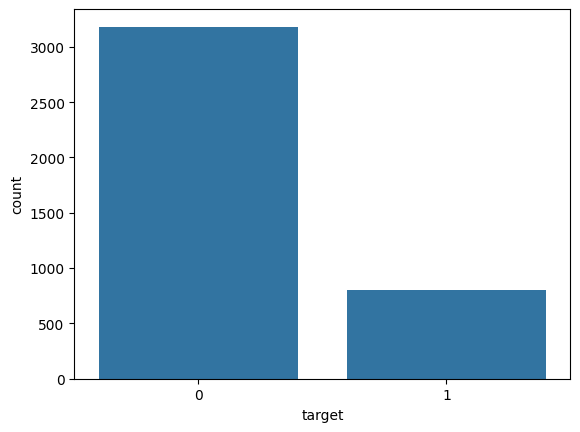

In [150]:
sns.countplot(data=df, x='target')

It can be noticed, that the target value is imbalanced. There are much more 0 values than 1 values in the dataset. This fact will have to be adressed both during building a model and choosing appropriate validation metric.

The most commonly used metric for classification problems is Accuracy. It is the ratio of correct predictions to all predictions. But it is not a proper metric if we work with imbalanced data. For example, if we created a dummy model, that always returned 0 as a result, it would have accuracy of 80%.

In this case, the suitable metric is F1 score, which is the harmonic mean of precision and recall.

In [151]:
df['target'].value_counts()[0]/df.__len__()

0.7990959316926167

# Building the models

To start with, let's see what results can get only on structured data. 3 models will be compared: RandomForestClassifier, XGBClassifier and Pytorch Neural Network.

## Random Forest:

In [152]:
X = df.drop(['target', 'user_id'], axis=1)
y = df['target']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", max_depth=100)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_classifier.predict(X_val)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8318695106649937
F1 score: 0.40707964601769914
Confusion Matrix:
 [[617  20]
 [114  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       637
           1       0.70      0.29      0.41       160

    accuracy                           0.83       797
   macro avg       0.77      0.63      0.65       797
weighted avg       0.81      0.83      0.80       797



## XGBoost:

We use scale_pos_weight parameter, to assign higher weight to '1' class to deal with imbalance:

In [153]:
# Create the XGBoost classifier
num_classes = len(np.unique(y_train)) # Number of classes in the target
scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8168130489335006
F1 score: 0.5680473372781065
Confusion Matrix:
 [[555  82]
 [ 64  96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       637
           1       0.54      0.60      0.57       160

    accuracy                           0.82       797
   macro avg       0.72      0.74      0.73       797
weighted avg       0.82      0.82      0.82       797



Use Hyperopt to tune XGBoost hyperparameters and see if we can get better results:

In [154]:
ratio = sum(y_train==0)/sum(y_train==1) 

space = {'eta': hp.uniform("eta", 0.1, 0.5),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 10),
        "scale_pos_weight": hp.uniform('scale_pos_weight',ratio, ratio*1.5),
        'subsample': hp.uniform('subsample', 0.6, 1)
        }
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=space['colsample_bytree'], scale_pos_weight=space['scale_pos_weight'], colsample_bylevel=space['colsample_bylevel'], subsample=space['subsample'])
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_val)
    # pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(y_val, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.5892857142857143                                     
SCORE:                                                                            
0.5638297872340425                                                                
SCORE:                                                                            
0.5825242718446602                                                                
SCORE:                                                                            
0.5727699530516432                                                                
SCORE:                                                                            
0.5764966740576497                                                                
SCORE:                                                                            
0.5763546798029556                                                                
SCORE:                                                    

Show the best set of hyperparams:

In [155]:
best_hyperparams

{'colsample_bylevel': 0.742821390604545,
 'colsample_bytree': 0.7710973052716081,
 'eta': 0.21515571741523268,
 'gamma': 7.725348799644798,
 'max_depth': 14.0,
 'min_child_weight': 7.0,
 'n_estimators': 190.0,
 'reg_alpha': 0.2968438918479057,
 'reg_lambda': 0.3937456137192355,
 'scale_pos_weight': 4.162029874290932,
 'subsample': 0.6989022244349172}

Train and evaluate the model using the best set of hyperparameters:

In [156]:
best_model = xgb.XGBClassifier(
                    n_estimators =int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=best_hyperparams['colsample_bytree'], scale_pos_weight=best_hyperparams['scale_pos_weight'], 
                    colsample_bylevel=best_hyperparams['colsample_bylevel'], subsample=best_hyperparams['subsample'])

# Train the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8005018820577164
F1 score: 0.5954198473282443
Confusion Matrix:
 [[521 116]
 [ 43 117]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       637
           1       0.50      0.73      0.60       160

    accuracy                           0.80       797
   macro avg       0.71      0.77      0.73       797
weighted avg       0.84      0.80      0.81       797



The F1 score is a little better. Let's plot the confusion matrix:

Text(0.5, 1.0, 'Confusion Matrix')

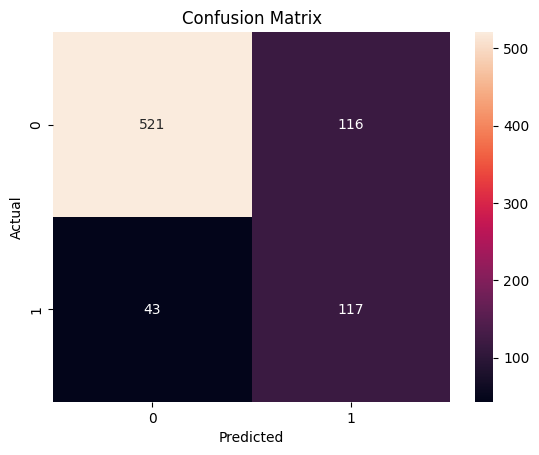

In [157]:
#plotting the confusion matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

We can see, that the model returns a lot of False Positive results.

## Neural Network

In [158]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Build simple NN with linear layers.

In [159]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build model
class NNClassifier(nn.Module):
    def __init__(self, input_features, hidden_units=8):
        """Initializes all required hyperparameters for a binary classification model.

        Args:
            input_features (int): Number of input features to the model.
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1),
            # nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Create an instance of BlobModel and send it to the target device
nnn_classifier = NNClassifier(input_features=X_train.shape[1], hidden_units=100).to(device)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([ratio]).to(device))
optimizer = torch.optim.SGD(nnn_classifier.parameters(), lr=0.025, momentum=0.1)
acc_fn = BinaryAccuracy().to(device)
f1_fn = BinaryF1Score().to(device)

# Fit the model
torch.manual_seed(42)
epochs = 2000

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.transform(X_val.values)

# Create tensors
X_train, y_train = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(y_train.values).type(torch.float)
X_val, y_val = torch.from_numpy(X_val).type(torch.float), torch.from_numpy(y_val.values).type(torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = nnn_classifier(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = acc_fn(y_pred, y_train)
    f1 = f1_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    nnn_classifier.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = nnn_classifier(X_val).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_val)
      test_acc = acc_fn(test_pred, y_val)
      test_f1 = f1_fn(test_pred, y_val)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%, F1: {f1:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}, Test F1: {test_f1:.2f}")

Epoch: 0 | Loss: 1.10819, Accuracy: 0.28%, F1: 0.32 | Test Loss: 1.10710, Test Accuracy: 0.20, Test F1: 0.33
Epoch: 100 | Loss: 1.10346, Accuracy: 0.42%, F1: 0.39 | Test Loss: 1.10375, Test Accuracy: 0.40, Test F1: 0.38
Epoch: 200 | Loss: 1.09736, Accuracy: 0.58%, F1: 0.44 | Test Loss: 1.09878, Test Accuracy: 0.58, Test F1: 0.43
Epoch: 300 | Loss: 1.08445, Accuracy: 0.64%, F1: 0.48 | Test Loss: 1.08819, Test Accuracy: 0.63, Test F1: 0.44
Epoch: 400 | Loss: 1.05458, Accuracy: 0.68%, F1: 0.49 | Test Loss: 1.06352, Test Accuracy: 0.67, Test F1: 0.46
Epoch: 500 | Loss: 0.98959, Accuracy: 0.72%, F1: 0.52 | Test Loss: 1.01144, Test Accuracy: 0.71, Test F1: 0.48
Epoch: 600 | Loss: 0.89480, Accuracy: 0.76%, F1: 0.55 | Test Loss: 0.94066, Test Accuracy: 0.74, Test F1: 0.49
Epoch: 700 | Loss: 0.81912, Accuracy: 0.78%, F1: 0.57 | Test Loss: 0.89391, Test Accuracy: 0.76, Test F1: 0.51
Epoch: 800 | Loss: 0.76937, Accuracy: 0.79%, F1: 0.59 | Test Loss: 0.87041, Test Accuracy: 0.76, Test F1: 0.51
Epo

F1 score: tensor(0.5418, device='cuda:0')


Text(0.5, 1.0, 'Confusion Matrix')

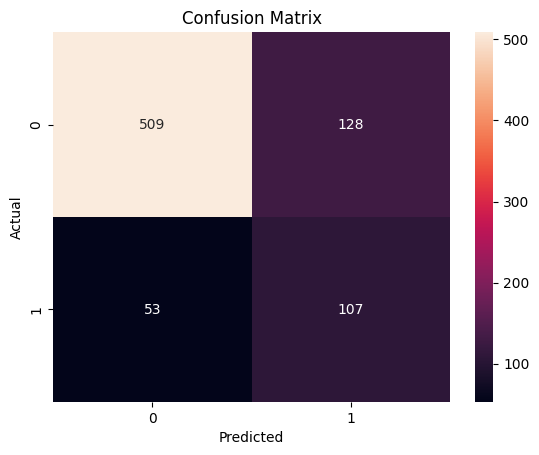

In [160]:
# Make predictions
nnn_classifier.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(nnn_classifier(X_val))).squeeze()

# Print F1 score
print("F1 score:",f1_fn(y_preds, y_val))

#plotting the confusion matrix
sns.heatmap(confusion_matrix(y_val.cpu(), y_preds.cpu()), annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

It performs worse.

# Adding unstructured data

The json file provided contains the list of interest groups for each user. The chosen approach to extract the features from such data is to merge the interest groups to one string for each user and calculate word embeddings using BERT model. What we get for each user, is the vector of fixed size representing the string containing all interest groups names of the user. Such vector can be added to the dataframe.

In [121]:
# loading json file
with open('data/train.json', encoding="utf8") as f:
    groups = json.load(f)

groups = groups['data']

# changing structure of the dictionary
interest_groups = {}
for group in groups:
    interest_groups[group['id']] = [element['group_name'] for element in group['groups']['data']]

# merging interest groups of each user to one string
interest_groups_joint = {}
for id, groups in interest_groups.items():
    interest_groups_joint[id] = ' '.join(groups)

Calculate embeddings:

In [122]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text, model, tokenizer):
    """
    Get BERT embeddings for a given text.
    
    Args:
    - text: Input text
    - model: Pre-trained BERT model
    - tokenizer: BERT tokenizer
    
    Returns:
    - BERT embeddings
    """
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # get the average embedding across all tokens in the input text:
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Calculate embeddings for each user
user_embeddings = {}
for user, groups in tqdm(interest_groups_joint.items()):
    user_embeddings[user] = get_bert_embedding(groups, model, tokenizer)

100%|██████████| 4000/4000 [04:59<00:00, 13.38it/s]


Create DataFrame with embeddings:

In [123]:
embeddings_df = pd.DataFrame({
    "user_id": user_embeddings.keys(),
    "embedding": user_embeddings.values()
})

# Split the embedding column into multiple columns
embeddings_df[['embedding_' + str(i) for i in range(list(user_embeddings.values())[0].shape[0])]] = pd.DataFrame(embeddings_df['embedding'].tolist(), index=embeddings_df.index)

# Drop the original embedding column
embeddings_df.drop(columns=['embedding'], inplace=True)

# Change user_id data type from string to int
embeddings_df['user_id'] = embeddings_df['user_id'].astype(int)

Add embeddings to the initial dataframe. To do it, we merge dataframes on 'user_id' column

In [161]:
df = df.merge(embeddings_df, on='user_id')

In [162]:
X = df.drop(['target', 'user_id'], axis=1)
y = df['target']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Create XGBoost

In [163]:
# Create the XGBoost classifier
ratio = sum(y_train==0)/sum(y_train==1)

model = xgb.XGBClassifier(scale_pos_weight=ratio)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9021329987452948
F1 score: 0.7310344827586207
Confusion Matrix:
 [[613  24]
 [ 54 106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       637
           1       0.82      0.66      0.73       160

    accuracy                           0.90       797
   macro avg       0.87      0.81      0.84       797
weighted avg       0.90      0.90      0.90       797



After using embeddings, the F1 score is much better. Let's tune the model hyperparameters.

In [164]:
space = {'eta': hp.uniform("eta", 0.1, 0.5),
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 10),
        "scale_pos_weight": hp.uniform('scale_pos_weight',ratio, ratio*1.5),
        'subsample': hp.uniform('subsample', 0.6, 1)
        }
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=space['colsample_bytree'], scale_pos_weight=space['scale_pos_weight'], colsample_bylevel=space['colsample_bylevel'], subsample=space['subsample'])
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_val)
    # pred = [1 if i>= 0.5 else 0 for i in pred]
    f1 = f1_score(y_val, pred)
    print ("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.7105263157894737                                     
SCORE:                                                                            
0.7467532467532467                                                                
SCORE:                                                                            
0.743421052631579                                                                 
SCORE:                                                                            
0.710691823899371                                                                 
SCORE:                                                                            
0.7560975609756098                                                                
SCORE:                                                                            
0.7460815047021944                                                                
SCORE:                                                    

Show best set of hyperparams:

In [165]:
best_hyperparams

{'colsample_bylevel': 0.6517150958485469,
 'colsample_bytree': 0.5278568350007665,
 'eta': 0.165313340871101,
 'gamma': 3.1613962727594584,
 'max_depth': 6.0,
 'min_child_weight': 9.0,
 'n_estimators': 130.0,
 'reg_alpha': 0.572222459002476,
 'reg_lambda': 0.860972766003877,
 'scale_pos_weight': 4.441653094974084,
 'subsample': 0.9067602462701283}

Train and evaluate the model with the best set of hyperparams:

In [166]:
best_model = xgb.XGBClassifier(
                    n_estimators =int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=best_hyperparams['colsample_bytree'], scale_pos_weight=best_hyperparams['scale_pos_weight'], 
                    colsample_bylevel=best_hyperparams['colsample_bylevel'], subsample=best_hyperparams['subsample'])

# Train the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9109159347553325
F1 score: 0.7672131147540984
Confusion Matrix:
 [[609  28]
 [ 43 117]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       637
           1       0.81      0.73      0.77       160

    accuracy                           0.91       797
   macro avg       0.87      0.84      0.86       797
weighted avg       0.91      0.91      0.91       797



Text(0.5, 1.0, 'Confusion Matrix')

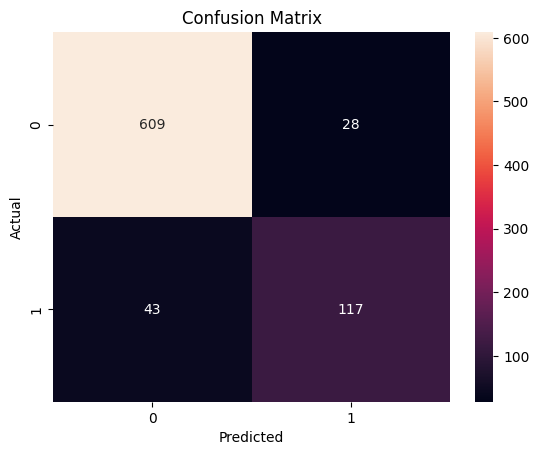

In [167]:
#plotting the confusion matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

## Neural Network

In [168]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build model
class NNClassifier(nn.Module):
    def __init__(self, input_features, hidden_units=8):
        """Initializes all required hyperparameters for a binary classification model.

        Args:
            input_features (int): Number of input features to the model.
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1),
            # nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

# Create an instance of BlobModel and send it to the target device
nn_classifier = NNClassifier(input_features=X_train.shape[1], hidden_units=500).to(device)

# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([ratio]).to(device))
optimizer = torch.optim.SGD(nn_classifier.parameters(), lr=0.005)
# optimizer = torch.optim.Adam(nn_classifier.parameters(), lr=0.001)
acc_fn = BinaryAccuracy().to(device)
f1_fn = BinaryF1Score().to(device)

# Fit the model
torch.manual_seed(42)
epochs = 2500

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.transform(X_val.values)

# Create tensors
X_train, y_train = torch.from_numpy(X_train).type(torch.float), torch.from_numpy(y_train.values).type(torch.float)
X_val, y_val = torch.from_numpy(X_val).type(torch.float), torch.from_numpy(y_val.values).type(torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = nn_classifier(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = acc_fn(y_pred, y_train)
    f1 = f1_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    nn_classifier.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = nn_classifier(X_val).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_val)
      test_acc = acc_fn(test_pred, y_val)
      test_f1 = f1_fn(test_pred, y_val)

    # Print out what's happening
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%, F1: {f1:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%, Test F1: {test_f1:.2f}")

Epoch: 0 | Loss: 1.10618, Accuracy: 0.52%, F1: 0.30 | Test Loss: 1.10669, Test Accuracy: 0.79%, Test F1: 0.04
Epoch: 100 | Loss: 1.10441, Accuracy: 0.52%, F1: 0.43 | Test Loss: 1.10428, Test Accuracy: 0.51%, Test F1: 0.43
Epoch: 200 | Loss: 1.10197, Accuracy: 0.45%, F1: 0.41 | Test Loss: 1.10206, Test Accuracy: 0.44%, Test F1: 0.41
Epoch: 300 | Loss: 1.09938, Accuracy: 0.52%, F1: 0.44 | Test Loss: 1.09978, Test Accuracy: 0.51%, Test F1: 0.44
Epoch: 400 | Loss: 1.09644, Accuracy: 0.62%, F1: 0.50 | Test Loss: 1.09718, Test Accuracy: 0.62%, Test F1: 0.49
Epoch: 500 | Loss: 1.09279, Accuracy: 0.69%, F1: 0.54 | Test Loss: 1.09391, Test Accuracy: 0.69%, Test F1: 0.54
Epoch: 600 | Loss: 1.08790, Accuracy: 0.75%, F1: 0.60 | Test Loss: 1.08950, Test Accuracy: 0.74%, Test F1: 0.58
Epoch: 700 | Loss: 1.08140, Accuracy: 0.78%, F1: 0.63 | Test Loss: 1.08367, Test Accuracy: 0.77%, Test F1: 0.61
Epoch: 800 | Loss: 1.07241, Accuracy: 0.81%, F1: 0.65 | Test Loss: 1.07555, Test Accuracy: 0.79%, Test F1:

Evaluate the model:

F1 score: tensor(0.6682, device='cuda:0')
None


Text(0.5, 1.0, 'Confusion Matrix')

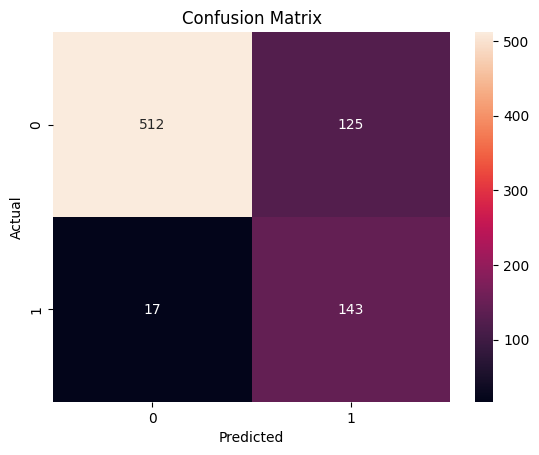

In [169]:
# Make predictions
nn_classifier.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(nn_classifier(X_val))).squeeze()

print(print("F1 score:",f1_fn(y_preds, y_val)))

#plotting the confusion matrix
sns.heatmap(confusion_matrix(y_val.cpu(), y_preds.cpu()), annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

It performs worse than XGBoost, so the final predictions will be done with XGBoost.

# Make predictions for test dataset

Modularize the structured and unstructured data preprocessing:

In [178]:
def preprocess_structured_data(csv_path):
    """
        Preprocess data from csv and prepare to be used in prediction model.
        
        Args:
        - csv_path: path to csv file
        
        Returns:
        - DataFrame
        """
    df = pd.read_csv(csv_path)

    nan_mask = df['sex'].isna()
    df.loc[nan_mask, 'sex'] = np.where(df.loc[nan_mask, 'name'].str.endswith('a'), 'female', 'male')

    # change dob column data type
    df['dob'] = pd.to_datetime(df['dob'])

    # function for calculating age:
    def dob_to_age(dob): 
        dob = dob.date() 
        today = date.today() 
        return today.year - dob.year - ((today.month,  today.day) < (dob.month,  dob.day))

    # create 'age' column
    df['age'] = df['dob'].apply(dob_to_age)

    # drop 'dob' column
    df.drop(['dob'], axis=1, inplace=True)

    df['age'].fillna(df['age'].mean(), inplace=True)
    df['daily_commute'].fillna(df['daily_commute'].mean(), inplace=True)
    df['relationship_status'] = na_randomfill(df['relationship_status'])
    df['credit_card_type'] = na_randomfill(df['credit_card_type'])
    df['education'].fillna(df['education'].mode().values[0], inplace=True)

    df['hobbies'].fillna("no_hobbies", inplace=True)
    encoded = df['hobbies'].to_list()
    encoded = [s.split(",") for s in encoded]
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(encoded)
    df_encoded = pd.DataFrame(encoded, columns=mlb.classes_, index=df.index)
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=["hobbies"], inplace=True)
    
    for feature_name in ['sex']:
        df[feature_name] = label_encode(df[feature_name])

    for feature_name in ['occupation', 'relationship_status', 'credit_card_type']:
        df = one_hot_encode_column(df, feature_name)
    
    df.drop(["name", 'location', 'location_from'], inplace=True, axis=1)

    return df

def unstructured_to_features(json_path):
    """
        Read unstructured data with interest groups for each user from json file and extract features from it using word embedding from BERT model.
        
        Args:
        - json_path: path to json file
        
        Returns:
        - DataFrame with user_ids and embeddings
        """
    # loading json file
    with open(json_path, encoding="utf8") as f:
        groups = json.load(f)

    groups = groups['data']

    # changing structure of the dictionary
    interest_groups = {}
    for group in groups:
        interest_groups[group['id']] = [element['group_name'] for element in group['groups']['data']]

    # merging interest groups of each user to one string
    interest_groups_joint = {}
    for id, groups in interest_groups.items():
        interest_groups_joint[id] = ' '.join(groups)

    # Load pre-trained BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Calculate embeddings for each user
    user_embeddings = {}
    for user, groups in tqdm(interest_groups_joint.items()):
        user_embeddings[user] = get_bert_embedding(groups, model, tokenizer)

    # Create DataFrame with embeddings
    embeddings_df = pd.DataFrame({
        "user_id": user_embeddings.keys(),
        "embedding": user_embeddings.values()
    })

    # Split the embedding column into multiple columns
    embeddings_df[['embedding_' + str(i) for i in range(list(user_embeddings.values())[0].shape[0])]] = pd.DataFrame(embeddings_df['embedding'].tolist(), index=embeddings_df.index)

    # Drop the original embedding column
    embeddings_df.drop(columns=['embedding'], inplace=True)

    # Change user_id data type from string to int
    embeddings_df['user_id'] = embeddings_df['user_id'].astype(int)

    return embeddings_df


def get_bert_embedding(text, model, tokenizer):
        """
        Get BERT embeddings for a given text.
        
        Args:
        - text: Input text
        - model: Pre-trained BERT model
        - tokenizer: BERT tokenizer
        
        Returns:
        - BERT embeddings
        """
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings

Preprocess test data and prepare datasets for making predictions:

In [179]:
test_df = preprocess_structured_data('data/test.csv')

test_embeddings_df = unstructured_to_features('data/test.json')

test_df = test_df.merge(test_embeddings_df, on='user_id')

test_df.drop(columns=['user_id', 'target'], inplace=True)

100%|██████████| 2000/2000 [02:12<00:00, 15.11it/s]


Make predictions using XGBoost model with tuned hyperparameters:

In [180]:
# Make predictions
y_test_pred = best_model.predict(test_df)

# Get probablilities
y_test_proba = best_model.predict_proba(test_df)
# Get probabilities of 1:
y_test_proba = y_test_proba[:,1]

Save results to a scored file:

In [185]:
results = pd.DataFrame({
    "user_id": np.arange(2000),
    "probability_of_one": y_test_proba,
    "target": y_test_pred
})

In [187]:
results.to_csv('test.csv',index=False)